In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn


import monai
from monai.handlers import CheckpointSaver, MeanDice, StatsHandler, ValidationHandler
from monai.transforms import (
    AddChanneld,
    AsDiscreted,
    CastToTyped,
    LoadNiftid,
    Orientationd,
    RandAffined,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandGaussianNoised,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    ToTensord,
)

np.random.seed(0)
#torch.manual_seed(0)!pip install monai

In [2]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Down_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv_3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Up_3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up   = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv_3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class OutConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv_3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc   = DoubleConv_3D(n_channels, 16)
        self.down1 = Down_3D(16, 32)
        self.down2 = Down_3D(32, 64)
        self.down3 = Down_3D(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down_3D(128, 256 // factor)
        self.up1 = Up_3D(256, 128 // factor, bilinear)
        self.up2 = Up_3D(128, 64 // factor, bilinear)
        self.up3 = Up_3D(64, 32 // factor, bilinear)
        self.up4 = Up_3D(32, 16, bilinear)
        self.outc = OutConv_3D(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_with_BN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_with_BN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.BatchNorm2d(16)
        self.gn2 = nn.BatchNorm2d(32)
        self.gn3 = nn.BatchNorm2d(64)
        self.gn4 = nn.BatchNorm2d(128)
        self.gn5 = nn.BatchNorm2d(64)
        self.gn6 = nn.BatchNorm2d(32)
        self.gn7 = nn.BatchNorm2d(16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_without_GN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_without_GN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x, x3)
        x  = self.up3(x, x2)
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        self.lsgn2 = nn.GroupNorm(64,1024)
        self.lsgn3 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        #x5 = self.gn
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo   = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        #x5 = self.lsgn3(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = max_length
        self.bilinear    = bilinear
        self.n_classes   = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn      = nn.Linear(2048, 1024)
        
        self.attn2   = nn.Linear(1024, 128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru     = nn.GRU(1024, 1024)
        self.out     = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        #self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsbn_a1 = nn.BatchNorm1d(1024)
        #self.lsgn_a2 = nn.GroupNorm(512,1024)
        
        #self.lsgn_in = nn.GroupNorm(64,128)
        self.lsbn_in1 = nn.BatchNorm1d(2048)
        self.lsbn_in2 = nn.BatchNorm1d(1024)
        
        
        self.lsbn_in3 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in4 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in5 = nn.BatchNorm1d(1024)#nn.GroupNorm(512,  1024)
        
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h        = torch.unsqueeze(hidden, 0)
        embedded = input
        #embedded = self.lsgn_in1(embedded)
        embedded = self.dropout(embedded)
        
        hidden_bilstm = h[0]
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        hidden_bilinn = self.lsbn_a1(hidden_bilinn)
        
        hidden_bi     = hidden_bilinn.unsqueeze(0)
        
        #print(hidden_bilinn.shape)
        
        attn_weights  = torch.cat((embedded[0], hidden_bilinn), 1)
        attn_weights  = self.lsbn_in1(attn_weights)
        
        attn_weights  = self.attn(attn_weights)
        attn_weights  = self.lsbn_in2(attn_weights)
        
        attn_weights  = F.softmax(attn_weights, dim=1)
        
        attn_weights  = self.attn2(attn_weights)
        attn_weights  = self.lsbn_in3(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        output = F.relu(output)
        output = self.lsbn_in4(output)
        
        output, hidden = self.gru(output, hidden_bi)
        
        output = self.out(output[0])
        output = self.lsbn_in5(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out
    
class UNetNormal(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetNormal, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        my_factor = 1
        factor    = 1
        
        self.inc   = DoubleConv(n_channels, 32*my_factor)
        self.down1 = Down(32*my_factor, 64*my_factor)
        self.down2 = Down(64*my_factor, 128*my_factor)
        self.down3 = Down(128*my_factor, 256*my_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(256*my_factor, 512*my_factor // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(512*my_factor, 256*my_factor // factor, bilinear)
        self.up2 = Up(256*my_factor, 128*my_factor // factor, bilinear)
        self.up3 = Up(128*my_factor, 64*my_factor // factor, bilinear)
        self.up4 = Up(64*my_factor, 32*my_factor, bilinear)
        self.outc = OutConv(32*my_factor, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet_3D(1, 1)
#model.cuda()

In [ ]:
# [STAR] For training different models for comparison on MOSMEDDATA dataset

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
basepath_models  = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return
device         = torch.device("cuda:0")


train_ids      = np.load(basepath+'TRAIN.npy')
val_ids        = np.load(basepath+'VALIDATION.npy')
test_ids       = np.load(basepath+'TEST.npy')
unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
#nocovid_ids    = np.load(basepath+'NOCOVID.npy')


unlabelled_ids     = unlabelled_ids
train_ids          = train_ids#[:4]
val_ids            = val_ids
test_ids           = test_ids

trainx_l, trainy_l = read_training_data(train_ids)
valx, valy         = read_training_data(val_ids)
testx, testy       = read_training_data(test_ids)

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)
            
prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())


val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 100


teacher_dice_array = []
for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)

    train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy)
    
    val_dice      = evaluate_result(model_student, valx, valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    
    model_save_name = "tmi-compare-sunet"
    
    if np.mean(val_dice) > prev_max:
        print("Step %d  Dice %.5f > %f  Train Dice %f " % (epoch, np.mean(val_dice), prev_max, np.mean(student_dice1)))
        prev_max     = np.mean(val_dice)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [81]:
# [STAR] For training models on Challenge Dataset

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np
import time

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
from scipy.ndimage import rotate

basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(len(models)):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(len(models)):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(len(models)):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
       
        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            t1 = output[0, 0].astype('uint8')#scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = y[0, 0]#scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            t1 = random.randint(0, 100)
            if t1 > 60:
                for k in range(x.shape[0]):
                    rotv = random.randint(0, 3)
                    x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                    y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return
device         = torch.device("cuda:0")


covid19 = True
mosmed  = False

# For COVID-19 dataset
if covid19:
    trainx_l = (np.load(basepath+'train_x_challenge.npy')+1500.0)/1500.0
    trainx_l[trainx_l > 1] = 1
    trainx_l[trainx_l < 0] = 0
    
    trainy_l = np.load(basepath+'train_y_challenge.npy')
    trainy_l[trainy_l > 0] = 1
    
    #index  = np.random.permutation(trainx_l.shape[0])
    #trainx_l = trainx_l[index]
    #trainy_l = trainy_l[index]
    
    train_size    = 4000
    val_size      = 400
    
    testx         = trainx_l[train_size+val_size:]
    testy         = trainy_l[train_size+val_size:]
    
    valx          = testx#trainx_l[train_size: train_size+val_size]
    valy          = testy#trainy_l[train_size: train_size+val_size]

    trainx_l = trainx_l[:train_size]
    trainy_l = trainy_l[:train_size]

    #testx = #np.load(basepath+'test_x.npy')/255.0
    #testy = #np.load(basepath+'test_y.npy')
    #testy[testy > 0] = 1

    #trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
    #valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
    #testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')
    
    #trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
    #valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
    #testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')
    
    #for i in range(trainx_l.shape[0]):
    #    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    #    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

    #for i in range(valx.shape[0]):
    #    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    #    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)
    
    #for i in range(testx.shape[0]):
    #    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    #    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)
    
    #trainx_l = trainx_l1
    #trainy_l = trainy_l1
    #valx     = valx1
    #valy     = valy1
    #testx    = testx1
    #testy    = testy1
    
# For Mosmed Dataset
if mosmed:
    basepath         = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
    basepath_models  = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'

    train_ids      = np.load(basepath+'TRAIN.npy')
    val_ids        = np.load(basepath+'VALIDATION.npy')
    test_ids       = np.load(basepath+'TEST.npy')
    
    train_ids          = train_ids
    val_ids            = val_ids
    test_ids           = test_ids
    
    trainx_l, trainy_l = read_training_data(train_ids)
    valx, valy         = read_training_data(val_ids)
    testx, testy       = read_training_data(test_ids)
    

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)
            

#model_student   = AttU_Net(1, 1)

#trainx, trainy = sort_data(trainx_l, trainy_l)

for ktr in range(0, 0):
    prev_max        = -1000
    model_student   = SUNet(1, 1)
    model_student.cuda()

    #optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001, betas=(0.8, 0.9))
    optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001, betas=(0.9, 0.99))
    criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())


    val_dice_array   = []
    train_dice_array = []
    test_dice_array  = []

    
    total_epochs = 50

    teacher_dice_array = []
    start_time = time.time()
    
    index  = np.random.choice(len(trainx_l), 3500)
    trainx = trainx_l#[index]
    trainy = trainy_l#[index]
    
    for epoch in range(0, total_epochs):
        if epoch%5 ==1:
            print(epoch)

        index  = np.random.permutation(trainx.shape[0])
        trainx = trainx[index]
        trainy = trainy[index]

        train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, True)

        #pred          = get_prediction(model_student, valx)
        #val_dice      = evaluate_result(model_student, valx, valy)

        #pred          = get_prediction(model_student, trainx)
        student_dice1 = evaluate_result(model_student, trainx, trainy)

        #pred          = get_prediction(model_student, testx)
        student_dice2 = evaluate_result(model_student, testx, testy)
        val_dice      = student_dice2

        train_dice_array.append(np.mean(student_dice1))
        val_dice_array.append(np.mean(val_dice))
        test_dice_array.append(np.mean(student_dice2))

        model_save_name = "tmi-covid19-challenge19-"+str(ktr)

        current_time = time.time()

        print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)), current_time-start_time)
        if np.mean(val_dice) > prev_max:
            prev_max     = np.mean(val_dice)
            torch.save(model_student.state_dict(), basepath_models+model_save_name+".pt")

        start_time   = current_time

# # tmi-covid19-challenge7  -> 58 
# # tmi-covid19-challenge9  -> 61 
# # tmi-covid19-challenge10 -> 63 
# # tmi-covid19-challenge12 -> 61 
# tmi-covid19-challenge15-B-39 -> 0.595 (sunet 0.0001, with augmentation)

(4000, 1, 512, 512) (581, 1, 512, 512) (581, 1, 512, 512)


In [ ]:
# [STAR] For creating the Data Loaders

def get_xforms(mode="train", keys=("image", "label")):
    """returns a composed transform for train/val/infer."""

    xforms = [
        LoadNiftid(keys),
        AddChanneld(keys),
        Orientationd(keys, axcodes="LPS"),
        Spacingd(keys, pixdim=(1, 1, 3.0), mode=("bilinear", "nearest")[: len(keys)]),
        ScaleIntensityRanged(keys[0], a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
    ]
    if mode == "train":
        xforms.extend(
            [
                SpatialPadd(keys, spatial_size=(192, 192, -1), mode="reflect"),  # ensure at least 192x192
                RandAffined(
                    keys,
                    prob=0.15,
                    rotate_range=(-0.05, 0.05),
                    scale_range=(-0.1, 0.1),
                    mode=("bilinear", "nearest"),
                    as_tensor_output=False,
                ),
                RandCropByPosNegLabeld(keys, label_key=keys[1], spatial_size=(192, 192, 16), num_samples=3),
                #RandGaussianNoised(keys[0], prob=0.15, std=0.01),
                RandFlipd(keys, spatial_axis=0, prob=0.5),
                RandFlipd(keys, spatial_axis=1, prob=0.5),
                RandFlipd(keys, spatial_axis=2, prob=0.5),
            ]
        )
        dtype = (np.float32, np.uint8)
    if mode == "val":
        dtype = (np.float32, np.uint8)
    if mode == "infer":
        dtype = (np.float32,)
    xforms.extend([CastToTyped(keys, dtype=dtype), ToTensord(keys)])
    return monai.transforms.Compose(xforms)


data_folder  = '/media/yu-hao/WindowsData/COVID-19-20_v2/Train/'
model_folder = './runs1/'

"""run a training pipeline."""

images = sorted(glob.glob(os.path.join(data_folder, "*_ct.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_folder, "*_seg.nii.gz")))
#logging.info(f"training: image/label ({len(images)}) folder: {data_folder}")

amp  = True  # auto. mixed precision
keys = ("image", "label")
train_frac, val_frac = 0.8, 0.2
n_train = int(train_frac * len(images)) + 1
n_val   = min(len(images) - n_train, int(val_frac * len(images)))
#logging.info(f"training: train {n_train} val {n_val}, folder: {data_folder}")

train_files = [{keys[0]: img, keys[1]: seg} for img, seg in zip(images[:n_train], labels[:n_train])]
val_files = [{keys[0]: img, keys[1]: seg} for img, seg in zip(images[-n_val:], labels[-n_val:])]

# create a training data loader
batch_size = 2
#logging.info(f"batch size {batch_size}")
train_transforms = get_xforms("train", keys)
train_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.25)
train_loader = monai.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

# create a validation data loader
val_transforms = get_xforms("val", keys)
val_ds = monai.data.CacheDataset(data=val_files, transform=val_transforms, cache_num=10)
val_loader = monai.data.DataLoader(
    val_ds,
    batch_size=1,  # image-level batch to the sliding window method, not the window-level batch
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

# create BasicUNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net    = SUNet_3D(1, 2)
net    = net.to(device)
max_epochs, lr, momentum = 500, 1e-3, 0.95
#logging.info(f"epochs {max_epochs}, lr {lr}, momentum {momentum}")
opt = torch.optim.Adam(net.parameters(), lr=lr)

# create evaluator (to be used to measure model quality during training
val_post_transform = monai.transforms.Compose(
    [AsDiscreted(keys=("pred", "label"), argmax=(True, False), to_onehot=True, n_classes=2)]
)
val_handlers = [
    ProgressBar(),
    CheckpointSaver(save_dir=model_folder, save_dict={"net": net}, save_key_metric=True, key_metric_n_saved=3),
]
evaluator = monai.engines.SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    inferer=get_inferer(),
    post_transform=val_post_transform,
    key_val_metric={
        "val_mean_dice": MeanDice(include_background=False, output_transform=lambda x: (x["pred"], x["label"]))
    },
    val_handlers=val_handlers,
    amp=amp,
)

# evaluator as an event handler of the trainer
train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
]
trainer = monai.engines.SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=DiceCELoss(),
    inferer=get_inferer(),
    key_train_metric=None,
    train_handlers=train_handlers,
    amp=amp,
)
trainer.run()

In [ ]:
from ignite.contrib.handlers import ProgressBar
class DiceCELoss(nn.Module):
    """Dice and Xentropy loss"""

    def __init__(self):
        super().__init__()
        self.dice = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        dice = self.dice(y_pred, y_true)
        # CrossEntropyLoss target needs to have shape (B, D, H, W)
        # Target from pipeline has shape (B, 1, D, H, W)
        cross_entropy = self.cross_entropy(y_pred, torch.squeeze(y_true, dim=1).long())
        return dice + cross_entropy
def get_inferer(_mode=None):
    """returns a sliding window inference instance."""

    patch_size = (192, 192, 16)
    sw_batch_size, overlap = 2, 0.5
    inferer = monai.inferers.SlidingWindowInferer(
        roi_size=patch_size,
        sw_batch_size=sw_batch_size,
        overlap=overlap,
        mode="gaussian",
        padding_mode="replicate",
    )
    return inferer

val_handlers = [
    ProgressBar(),
    CheckpointSaver(save_dir='./runs1/', save_dict={"net": net}, save_key_metric=True, key_metric_n_saved=3),
]
evaluator = monai.engines.SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    inferer=get_inferer(),
    post_transform=val_post_transform,
    key_val_metric={
        "val_mean_dice": MeanDice(include_background=False, output_transform=lambda x: (x["pred"], x["label"]))
    },
    val_handlers=val_handlers,
    amp=amp,
)

# evaluator as an event handler of the trainer
train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
]
trainer = monai.engines.SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=DiceCELoss(),
    inferer=get_inferer(),
    key_train_metric=None,
    train_handlers=train_handlers,
    amp=amp,
)
trainer.run()

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(len(models)):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(len(models)):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(len(models)):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum*1.0/len(models)
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
       
        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            t1 = output[0, 0].astype('uint8')#scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = y[0, 0]#scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

In [83]:
models = []
all_weights = glob.glob('/home/yu-hao/SEMISUNET/Dataset/models/tmi-covid19-challenge19-*')
#all_weights2 = glob.glob('/home/yu-hao/SEMISUNET/Dataset/models/tmi-covid19-challenge16-*')
#all_weights = np.concatenate([all_weights1, all_weights2])

for p in all_weights:
    model_student   = SUNet(1, 1)
    model_student.cuda()
    model_student.load_state_dict(torch.load(p))
    models.append(model_student)

result = get_predictions(models, testx)
print(result.shape, testx.shape)

(581, 1, 512, 512) (581, 1, 512, 512)


In [84]:
dice_values = evaluate_result_new(result, testy)
print(len(dice_values))

581


In [48]:
print(np.mean(dice_values))

0.6543761573626149


(512, 512) (512, 512)


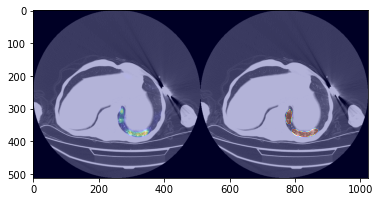

In [31]:
from scipy.ndimage import rotate
index = random.randint(0, testx.shape[0]-1)
img        = testx[index, 0]
img_mask   = result[index, 0]
img        = img.astype('float32')

rotate_img      = img#rotate(img,      -35, reshape=False)
rotate_img_mask = testy[index, 0]#rotate(img_mask, -35, reshape=False, order=1)
print(img.shape, rotate_img.shape)

plt.imshow(np.concatenate([img, rotate_img], axis=-1), cmap='gray')
plt.imshow(np.concatenate([img_mask, rotate_img_mask], axis=-1), cmap='jet', alpha=0.3)

In [9]:
model_student   = SUNet(1, 1)
model_student.cuda()
model_student.load_state_dict(torch.load(basepath_models+'tmi-covid19-challenge10-66.pt'))

val_dice      = evaluate_result(model_student, valx, valy)
print(np.mean(val_dice))

0.6336016197230773


In [ ]:
# [STAR] For getting result for submission to the challenge website ENSEMBLE model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy

basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(len(models)):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(len(models)):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(len(models)):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum*1.0/len(models)
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
       
        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return
device         = torch.device("cuda:0")

models      = []
all_weights = glob.glob('/home/yu-hao/SEMISUNET/Dataset/models/tmi-covid19-challenge16-*')
for p in all_weights:
    model_student   = SUNet(1, 1)
    model_student.cuda()
    model_student.load_state_dict(torch.load(p))
    model_student.eval()
    models.append(model_student)


write_path = '/media/yu-hao/WindowsData/COVID-19-20_v2/Result/'
all_vols   = glob.glob('/media/yu-hao/WindowsData/COVID-19-20_v2/Validation/*')
sample_submission_path = '/home/yu-hao/Downloads/garbage1/SampleSubmission/SampleSubmission/'

for p in all_vols:
    name = p.split('/')[-1].split('-')[-1][1:-10]#split('_')[0][1:]
    
    temp = sitk.ReadImage(p)
    v = (sitk.GetArrayFromImage(temp)+1500.0)/1500.0
    v[v > 1] = 1
    v[v < 0] = 0
    v = np.expand_dims(v, axis=1)
    
    #print(v.shape, v.dtype)
    r =  get_predictions(models, v)
    r[r < 0.5] = 0
    r[r > 0.5] = 1
    
    r  = r.astype('uint8')
    
    rs = r[:, 0]
    rs =  sitk.GetImageFromArray(rs)
    
    sample  = sitk.ReadImage(sample_submission_path+name+'.nii.gz')
    sample1 = sitk.GetArrayFromImage(sample)
    rs.CopyInformation(sample)
    
    print(name, sample1.shape, r.shape, rs.GetSize())
    sitk.WriteImage(rs, write_path+name+'.nii.gz')
    print('-------------------------')

In [ ]:
# [STAR] For getting result for submission to the challenge website

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy

basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
       
        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return
device         = torch.device("cuda:0")


model_student   = SUNet(1, 1)
model_student.cuda()

#model_load_name = "tmi-covid19-challenge4-15" -> 60
model_load_name = "tmi-covid19-challenge10-66"

model_student.load_state_dict(torch.load(basepath_models+model_load_name+'.pt'))
model_student.eval()


write_path = '/media/yu-hao/WindowsData/COVID-19-20_v2/Result/'
all_vols   = glob.glob('/media/yu-hao/WindowsData/COVID-19-20_v2/Validation/*')
sample_submission_path = '/home/yu-hao/Downloads/garbage1/SampleSubmission/SampleSubmission/'

for p in all_vols:
    name = p.split('/')[-1].split('-')[-1][1:-10]#split('_')[0][1:]
    
    temp = sitk.ReadImage(p)
    v = (sitk.GetArrayFromImage(temp)+1024.0)/1024.0
    v[v > 1] = 1
    v[v < 0] = 0
    v = np.expand_dims(v, axis=1)
    
    #print(v.shape, v.dtype)
    r =  get_prediction(model_student, v)
    r[r < 0.5] = 0
    r[r > 0.5] = 1
    
    r  = r.astype('uint8')
    
    rs = r[:, 0]
    rs =  sitk.GetImageFromArray(rs)
    
    sample  = sitk.ReadImage(sample_submission_path+name+'.nii.gz')
    sample1 = sitk.GetArrayFromImage(sample)
    rs.CopyInformation(sample)
    
    print(name, sample1.shape, r.shape, rs.GetSize())
    sitk.WriteImage(rs, write_path+name+'.nii.gz')
    print('-------------------------')

In [ ]:
# [STAR] Active Learning

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy

basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def get_next_slice(model_student, remx, remy):
    noise       = np.random.normal(0, .1, remx.shape)
    new_signal1 = remx + noise
    
    pred  = get_prediction(model_student, remx)
    pred1 = get_prediction(model_student, new_signal1)
    
    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0

    pred1[pred1 > 0.5] = 1
    pred1[pred1 < 0.5] = 0

    arr = []
    for index in range(pred.shape[0]):
        arr.append(np.sum(np.abs(pred[index, 0]-pred1[index, 0]))*1.0/den)
    
    arr1  = np.argsort(arr)    
    temp1 = np.expand_dims(remx[arr1[-1]], 0)
    temp2 = np.expand_dims(remy[arr1[-1]], 0)
    
    return temp1, temp2, np.delete(remx, arr1[-1], 0), np.delete(remy, arr1[-1], 0)

device         = torch.device("cuda:0")


covid19 = True
mosmed  = False

# For COVID-19 dataset
if covid19:
    trainx_l = np.load(basepath+'train_x.npy')/255.0
    trainy_l = np.load(basepath+'train_y.npy')
    trainy_l[trainy_l > 0] = 1
    
    index  = np.random.permutation(trainx_l.shape[0])
    trainx_l = trainx_l[index]
    trainy_l = trainy_l[index]
    
    train_size    = 5
    val_size      = 5
    
    remaining_x   = trainx_l[train_size:-val_size]
    remaining_y   = trainy_l[train_size:-val_size]
    
    valx          = trainx_l[-val_size:]
    valy          = trainy_l[-val_size:]

    trainx_l = trainx_l[:train_size]
    trainy_l = trainy_l[:train_size]

    testx = np.load(basepath+'test_x.npy')/255.0
    testy = np.load(basepath+'test_y.npy')
    testy[testy > 0] = 1

    trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
    valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
    testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')
    remx1     = np.zeros([remaining_x.shape[0], 1, 512, 512],    dtype='float16')
    
    trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
    valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
    testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')
    remy1     = np.zeros([remaining_y.shape[0], 1, 512, 512],    dtype='float16')
    
    for i in range(trainx_l.shape[0]):
        trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
        trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

    for i in range(valx.shape[0]):
        valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
        valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)
    
    for i in range(remaining_x.shape[0]):
        remx1[i, 0] = scipy.ndimage.zoom(remaining_x[i], 2, order=3)
        remy1[i, 0] = scipy.ndimage.zoom(remaining_y[i], 2, order=0)
    
    for i in range(testx.shape[0]):
        testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
        testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)
    
    trainx_l = trainx_l1
    trainy_l = trainy_l1
    valx     = valx1
    valy     = valy1
    testx    = testx1
    testy    = testy1
    remx     = remx1
    remy     = remy1

# For Mosmed Dataset
if mosmed:
    basepath         = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
    basepath_models  = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'

    train_ids      = np.load(basepath+'TRAIN.npy')
    val_ids        = np.load(basepath+'VALIDATION.npy')
    test_ids       = np.load(basepath+'TEST.npy')
    
    train_ids          = train_ids
    val_ids            = val_ids
    test_ids           = test_ids
    
    trainx_l, trainy_l = read_training_data(train_ids)
    valx, valy         = read_training_data(val_ids)
    testx, testy       = read_training_data(test_ids)
    

print(trainx_l.shape, valx.shape, testx.shape, remx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)
            
prev_max        = -1000
#model_student   = AttU_Net(1, 1)
model_student   = SUNet(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())


val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx = trainx_l
trainy = trainy_l
#trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 100



#new_slice, remx = get_next_slice(model_student, remx)

teacher_dice_array = []
total_slices       = 40

torch.save(model_student.state_dict(), basepath_models+model_save_name+'-initweight.pt')

iteration_array = []

for kt in range(total_slices):
    for epoch in range(total_epochs):
        if epoch%10 ==1:
            print(epoch)

        index  = np.random.permutation(trainx.shape[0])
        trainx = trainx[index]
        trainy = trainy[index]

        train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, True)

        pred          = get_prediction(model_student, valx)
        val_dice      = evaluate_result_new(pred, valy)

        pred          = get_prediction(model_student, trainx)
        student_dice1 = evaluate_result_new(pred, trainy)

        pred          = get_prediction(model_student, testx)
        student_dice2 = evaluate_result_new(pred, testy)

        train_dice_array.append(np.mean(student_dice1))
        val_dice_array.append(np.mean(val_dice))
        test_dice_array.append(np.mean(student_dice2))

        model_save_name = "tmi-covid19-noise1"

        if np.mean(val_dice) > prev_max:
            print("Iteration %d Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (kt, epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
            prev_max     = np.mean(val_dice)
            torch.save(model_student.state_dict(), basepath_models+model_save_name+"-.pt")
        
    model_student.load_state_dict(torch.load(basepath_models+model_save_name+"-.pt"))
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred,     testy)
    iteration_array.append(np.mean(student_dice2))
    
    new_slice_x, new_slice_y, remx, remy = get_next_slice(model_student, remx, remy)
    
    model_student.load_state_dict(torch.load(basepath_models+model_save_name+'-initweight.pt'))
    
    prev_max = -1
    print('Before ', trainx.shape, trainy.shape)
    trainx = np.concatenate([trainx, new_slice_x])
    trainy = np.concatenate([trainy, new_slice_y])
    print('After ', trainx.shape, trainy.shape)

In [163]:
noise       = np.random.normal(0, .1, remx.shape)
new_signal1 = remx + noise

In [ ]:
index = random.randint(0, remx.shape[0]-1)
arr   = []

for index in range(remx.shape[0]-1):
    den = np.sum(pred[index, 0])
    arr.append([np.sum(np.abs(pred[index, 0]-pred1[index, 0]))*1.0/den, np.sum(np.abs(pred1[index, 0]-pred2[index, 0]))*1.0/den, np.sum(np.abs(pred[index, 0]-pred2[index, 0]))*1.0/den])
    print(index, np.sum(np.abs(pred[index, 0]-pred1[index, 0]))*1.0/den, np.sum(np.abs(pred1[index, 0]-pred2[index, 0]))*1.0/den, np.sum(np.abs(pred[index, 0]-pred2[index, 0]))*1.0/den)

arr = np.array(arr)
#plt.imshow(np.concatenate([remx[index, 0], remx[index, 0], new_signal1[index, 0], new_signal2[index, 0]], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([pred[index, 0], remy[index, 0], pred1[index, 0], pred2[index, 0]], axis=-1), cmap='jet', alpha=0.08)

In [111]:
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/trainx_mosmed.npy', trainx_l)
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/trainy_mosmed.npy', trainy_l)
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/valx_mosmed.npy', valx)
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/valy_mosmed.npy', valy)
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/testx_mosmed.npy', testx)
# np.save('/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/testy_mosmed.npy', testy)

In [ ]:
# [STAR] For training different models for comparison on COVID-19 dataset using LSTM Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'

def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 4
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 4
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 4
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
        
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids


covid19 = True
mosmed  = False

# For COVID-19 dataset
if covid19:
    trainx_l = np.load(basepath+'train_x.npy')/255.0
    trainy_l = np.load(basepath+'train_y.npy')
    trainy_l[trainy_l > 0] = 1

    train_size    = 45
    valx          = trainx_l[train_size:]
    valy          = trainy_l[train_size:]

    trainx_l = trainx_l[:train_size]
    trainy_l = trainy_l[:train_size]

    testx = np.load(basepath+'test_x.npy')/255.0
    testy = np.load(basepath+'test_y.npy')
    testy[testy > 0] = 1

    trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
    valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
    testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

    trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
    valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
    testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')
    
    for i in range(trainx_l.shape[0]):
        trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
        trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

    for i in range(valx.shape[0]):
        valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
        valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

    for i in range(testx.shape[0]):
        testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
        testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)
    
    trainx_l = trainx_l1
    trainy_l = trainy_l1
    valx     = valx1
    valy     = valy1
    testx    = testx1
    testy    = testy1

# For Mosmed Dataset
if mosmed:
    basepath         = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
    basepath_models  = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'

    train_ids      = np.load(basepath+'TRAIN.npy')
    val_ids        = np.load(basepath+'VALIDATION.npy')
    test_ids       = np.load(basepath+'TEST.npy')
    
    train_ids          = train_ids
    val_ids            = val_ids
    test_ids           = test_ids
    
    trainx_l, trainy_l = read_training_data(train_ids)
    valx, valy         = read_training_data(val_ids)
    testx, testy       = read_training_data(test_ids)

    
print(trainx_l.shape, valx.shape, testx.shape)


def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

attn_decoder1 = AttnDecoderRNN(256, 256, dropout_p=0.5)
attn_decoder1.cuda()

prev_max        = -1000
model_student   = UNetDoubleSmallGroupNormdifferent(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

optimizer_attn_w  = optim.Adam(attn_decoder1.parameters(), lr=0.001, weight_decay=1e-2)

# Good setting
# 0.5, 0.001, 0.001

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 200


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    
    index  = np.random.permutation(trainx.shape[0])
    trainx = trainx[index]
    trainy = trainy[index]
    
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model2(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    pred      = get_prediction(model_student, valx)
    val_dice1 = evaluate_result_new(pred, valy)
    #print(pred.shape, len(val_dice1), valy.shape)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    #print(pred.shape, len(student_dice2), testy.shape)
    
    #val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    #student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice1))
    test_dice_array.append(np.mean(student_dice2))

    #model_save_name = "ipmi-attentionlstm-covid19"
    model_save_name = "tmi-compare-lstm"
    
    #if np.mean(val_dice1) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice1), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice1)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-studentmodel.pt')
    torch.save(attn_decoder1.state_dict(), basepath_models+model_save_name+'-attention.pt')
    #attn_decoder1

In [ ]:
# [STAR] Double Attention Model

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.downnew =Down(16,16)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        
        self.upsam = nn.Upsample(scale_factor=2, mode='nearest')

        
        self.down5 = Down(128,256)
        
        self.ups3 = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        
        self.lsgn2 = nn.GroupNorm(64,1024)
        
        self.lsgnp1 = nn.GroupNorm(128,256)
        
        self.lsgnp2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5:',x5.shape)
        
        ############### first attention layer for size 128,32,32 ---part 1 ######################
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        #print(f.shape)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        x5 = self.lsgn1(x5)
        ############### second attention layer for size 256,16,16 ---part 2 ######################
        x5 = self.down5(x5)
        xlst = x5.reshape([4,256,256])
        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgnp1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
    
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder2.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgnp2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        x5 = self.lsgnp2(x5)
        
        x5 = self.ups4(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN_2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)
        
        embedded =self.lsgn_a(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)


        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        output = self.lsgn_a(output)
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(2048, 1024)
        
        self.attn2 = nn.Linear(1024,128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(1024, 1024)
        self.out = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(512,1024)
        
        self.lsgn_in = nn.GroupNorm(64,128)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)
        
        embedded = self.lsgn_in(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        
        
        hidden_bilinn = self.attn(hidden_bilinn)
        
        #print('hidden bilinn shape:',hidden_bilinn.shape)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)
        #print(hidden_bilinn.shape)
        

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
        
        attn_weights  = self.attn2(attn_weights)
        
        attn_weights = self.lsgn_in(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        
        #print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        output = self.lsgn_in(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        

    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)


trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 45
valx          = trainx_l[train_size:]
valy          = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx     = valx1
valy     = valy1
testx    = testx1
testy    = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)


attn_decoder1 = AttnDecoderRNN(256, 256,dropout_p=0.85)
attn_decoder1.cuda()

attn_decoder2 = AttnDecoderRNN_2(256, 256,dropout_p=0.85)
attn_decoder2.cuda()

model_student = UNetDoubleSmallGroupNormdifferent(1,1)
model_student.cuda()


optimizer_student    = optim.Adam(model_student.parameters(), lr=0.0001,weight_decay=1e-5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


optimizer_attn_w    = optim.Adam(attn_decoder1.parameters(), lr=0.0001,weight_decay=1e-5)
optimizer_attn_w_2  = optim.Adam(attn_decoder2.parameters(), lr=0.0001,weight_decay=1e-5)


criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())


val_loss_array   = []
train_loss_array = []


def train_model(model, optimizer, criterion, trainx, trainy, augment=False):
    batch_size = 4
    loss_array = []
   
    model.train()

   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
              
  
        if(x.shape[0]!=4):
            break
            
        x = np.expand_dims(x, 1)
        
        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        optimizer_attn_w_2.zero_grad()
        
        output = model.forward(x)
        loss   = criterion(output , y)
        loss.backward()
           
        loss_array.append(loss.item())

    #    torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
        
        optimizer_attn_w_2.step()
   
    loss_array = np.mean(loss_array)
    return loss_array


batch_size = 4
teacher_dice_array = []
test_dice_array    = []
total_epochs       = 1000

for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    
    index  = np.random.permutation(trainx.shape[0])
    trainx = trainx[index]
    trainy = trainy[index]
    
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    pred      = get_prediction(model_student, valx)
    val_dice1 = evaluate_result_new(pred, valy)
    #print(pred.shape, len(val_dice1), valy.shape)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    #print(pred.shape, len(student_dice2), testy.shape)
    
    #val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    #student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice1))
    test_dice_array.append(np.mean(student_dice2))

    #model_save_name = "ipmi-attentionlstm-covid19"
    model_save_name = "tmi-compare-lstm"
    
    #if np.mean(val_dice1) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice1), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice1)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-double-studentmodel.pt')
    torch.save(attn_decoder1.state_dict(), basepath_models+model_save_name+'-double-attention.pt')
    #attn_decoder1

In [ ]:
# [STAR] For training different models for comparison on COVID-19 dataset using SU-Net Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
        
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

#index    = np.random.permutation(trainx_l.shape[0])
#trainx_l = trainx_l[index]
#trainy_l = trainy_l[index]

train_size    = 45
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = trainx_l, trainy_l
trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 30


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    pred      = get_prediction(model_student, valx)
    val_dice1 = evaluate_result_new(pred, valy)
    print(pred.shape, len(val_dice1), valy.shape)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    print(pred.shape, len(student_dice2), testy.shape)
    
    #val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    #student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice1))
    test_dice_array.append(np.mean(student_dice2))

    model_save_name = "ipmi-sunet-covid19"
    
    if np.mean(val_dice1) > prev_max:
        print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice1), np.mean(student_dice1), np.mean(student_dice2)))
        prev_max     = np.mean(val_dice1)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-6.pt')

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [ ]:
# [STAR] Semi-supervised training SU-Net Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, datax):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(datax)//batch_size):
        x = datax[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 45
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1

unlabelledx_l = np.load(basepath+'unlabelled_x.npy')/255.0


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')
unlabelledx1    = np.zeros([unlabelledx_l.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')

for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)

for i in range(unlabelledx1.shape[0]):
    unlabelledx1[i, 0] = scipy.ndimage.zoom(unlabelledx_l[i], 2, order=3)
    #testy1[i, 0] = scipy.ndimage.zoom(unlabelledy1[i], 2, order=0)

model_student   = SUNet(1, 1)
model_student.cuda()
p1         = torch.load(basepath_models+"tmi-compare-sunet-covid19-30.pt")
model_student.load_state_dict(p1)


unlabelledy1 = get_prediction(model_student, unlabelledx1)

trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape, unlabelledy1.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()
p1         = torch.load(basepath_models+"tmi-compare-sunet-covid19-30.pt")
model_student.load_state_dict(p1)

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
#criterion          = nn.MSELoss()

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

#trainy[trainy > 0.5] = 1
#trainy[trainy < 0.5] = 0
total_epochs     = 1000
#trainx, trainy   = sort_data(trainx, trainy)

trainx = trainx#[800:]
trainy = trainy#[800:]
# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []

index        = np.random.permutation(np.arange(len(unlabelledx1)))
unlabelledx1 = unlabelledx1[index]
unlabelledy1 = unlabelledy1[index]

for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    
    # Re-generate pseudo labels again
    if epoch%5 == 0:
        step_size        = len(unlabelledx1)//20-1
        inputx           = unlabelledx1#[0:(1+epoch%20)*step_size]
        unlabelledy1     = get_prediction(model_student, inputx)
        #unlabelledy1[unlabelledy1 < 0.5] = 0
        #unlabelledy1[unlabelledy1 > 0.5] = 1
        trainx_l1        = inputx#np.concatenate([trainx_l, inputx], axis=0)
        trainy_l1        = unlabelledy1#np.concatenate([trainy_l, unlabelledy1], axis=0)
        trainx, trainy   = sort_data(trainx_l1, trainy_l1)
    
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    test_dice_array.append(np.mean(student_dice2))
    
    
    model_save_name = "tmi-compare-sunet-covid19-semi"
    
    #if np.mean(val_dice) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [ ]:
# [STAR] Semi-supervised training LSTM Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'

def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, datax):
    output_array   = []
    batch_size     = 4
    
    model.eval()
    
    for ik in range(len(datax)//batch_size):
        x = datax[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 4
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 4
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
        
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 45
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1

unlabelledx_l = np.load(basepath+'unlabelled_x.npy')/255.0


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')
unlabelledx1    = np.zeros([unlabelledx_l.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')

for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)

for i in range(unlabelledx1.shape[0]):
    unlabelledx1[i, 0] = scipy.ndimage.zoom(unlabelledx_l[i], 2, order=3)
    #testy1[i, 0] = scipy.ndimage.zoom(unlabelledy1[i], 2, order=0)

model_save_name = "tmi-compare-lstm"

attn_decoder1 = AttnDecoderRNN(256, 256, dropout_p=0.45)
attn_decoder1.cuda()
p1         = torch.load(basepath_models+model_save_name+'-attention.pt')
attn_decoder1.load_state_dict(p1)

prev_max        = -1000
model_teacher   = UNetDoubleSmallGroupNormdifferent(1, 1)
model_teacher.cuda()
p1         = torch.load(basepath_models+model_save_name+'-studentmodel.pt')
model_teacher.load_state_dict(p1)


model_student   = UNetDoubleSmallGroupNormdifferent(1, 1)
model_student.cuda()

#model_student   = SUNet(1, 1)
#model_student.cuda()
#p1         = torch.load(basepath_models+model_save_name+'-studentmodel.pt')
#model_student.load_state_dict(p1)


unlabelledy1 = get_prediction(model_student, unlabelledx1)

trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape, unlabelledy1.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
#model_student   = SUNet(1, 1)
#model_student.cuda()
#p1         = torch.load(basepath_models+"tmi-compare-sunet-covid19-30.pt")
#model_student.load_state_dict(p1)

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.00001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
#criterion          = nn.MSELoss()

optimizer_attn_w  = optim.Adam(attn_decoder1.parameters(), lr=0.00001, weight_decay=1e-5)

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

#trainy[trainy > 0.5] = 1
#trainy[trainy < 0.5] = 0
total_epochs     = 1000
#trainx, trainy   = sort_data(trainx, trainy)

trainx = trainx#[800:]
trainy = trainy#[800:]
# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []

index        = np.random.permutation(np.arange(len(unlabelledx1)))
unlabelledx1 = unlabelledx1[index]
unlabelledy1 = unlabelledy1[index]

pred          = get_prediction(model_teacher, testx)
student_dice2 = evaluate_result_new(pred, testy)

print('Student Dice in beginning is ', np.mean(student_dice2))
    
for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    
    # Re-generate pseudo labels again
    #if epoch%5 == 0:
    step_size        = len(unlabelledx1)//20-1
    inputx           = unlabelledx1#[0:(1+epoch%20)*step_size]
    unlabelledy1     = get_prediction(model_teacher, inputx)
    unlabelledy1[unlabelledy1 < 0.5] = 0
    unlabelledy1[unlabelledy1 > 0.5] = 1
    trainx_l1        = inputx#np.concatenate([trainx_l, inputx], axis=0)
    trainy_l1        = unlabelledy1#np.concatenate([trainy_l, unlabelledy1], axis=0)
    index = np.random.permutation(np.arange(len(trainx_l1)))
    trainx_l1 = trainx_l1[index]
    trainy_l1 = trainy_l1[index]
    #trainx, trainy   = sort_data(trainx_l1, trainy_l1)
    
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model2(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    
    print('Student length is ', len(student_dice2))
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    test_dice_array.append(np.mean(student_dice2))
    
    
    model_save_name = "tmi-compare-lstm-semi"
    
    if np.mean(val_dice) > prev_max:
        print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
        prev_max     = np.mean(val_dice)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-modelstudent.pt')
        torch.save(attn_decoder1.state_dict(), basepath_models+model_save_name+'-attention.pt')
    
    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [ ]:
# [STAR] For training different models for comparison on COVID-19 dataset using SU-Net  Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 4
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 40
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = UNetDoubleSmallWithoutGN(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 1000


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    test_dice_array.append(np.mean(student_dice2))

    model_save_name = "tmi-compare-unet-covid19"
    
    #if np.mean(val_dice) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [ ]:
# [STAR] For training the Group Norm using un-labelled data


import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array).astype('float16')
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, optimizer, criterion, trainx, trainy):
    batch_size = 2
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy
        
train_ids      = np.load(basepath+'TRAIN.npy')
val_ids        = np.load(basepath+'VALIDATION.npy')
test_ids       = np.load(basepath+'TEST.npy')
unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')

train_ids           = train_ids

trainx_l, trainy_l = read_training_data(train_ids)
valx, valy         = read_training_data(val_ids)
testx, testy       = read_training_data(test_ids)

print(trainx_l.shape, valx.shape, testx.shape)

valx_img = sitk.GetImageFromArray(valx.astype('float32')[:, 0, :, :])
sitk.WriteImage(valx_img, basepath+'CT-img.nii.gz')


model_teacher = SUNet(1,1)#UNetDoubleSmall(1,1)
model_teacher.cuda()


p1         = torch.load(basepath_models+"tmi-f-3-93.pt")
model_teacher.load_state_dict(p1)


device             = torch.device("cuda:0")
optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0005)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_loss_array   = []
train_loss_array = []

prev_max_teacher = -1000
prev_max    = -1000
model_count = 0
step_size   = 20
beta        = 0.9

val_dice_t   = evaluate_result(model_teacher, valx, valy)
print("Dice in the beginning ", np.mean(val_dice_t))

val_dice_t = np.mean(val_dice_t)
prev_max   = val_dice_t

teacher_dice_array = []

train_dice_array = []
val_dice_array   = []
test_dice_array  = []

model_save_name = "tmi-f-semi-sunet"

first_time = True

for epoch in range(300):
    temp_index                 = epoch%(int(len(unlabelled_ids)/step_size))
    trainx1, trainx1_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
    trainy1                    = get_prediction(model_teacher, trainx1)
    
    trainx, trainy = sort_data(trainx1, trainy1)
    if epoch%10 == 0:
        print(epoch, trainx.shape, trainy.shape)
    
    train_loss = train_model(model_student, optimizer_student, criterion, trainx, trainy)
    
    train_dice = evaluate_result(model_student, trainx_l, trainy_l)
    val_dice   = evaluate_result(model_student, valx, valy)
    
    # Update teacher weights
    if np.mean(val_dice) > val_dice_t:
        print(epoch, ' Updating Teacher Weights')
        torch.save(model_student.state_dict(), "temp.pt")
        torch.save(model_student.state_dict(), basepath_models+model_save_name+".pt")
        p1         = torch.load('temp.pt')
        
        model_teacher.load_state_dict(p1)
        val_dice_t = np.mean(val_dice)
    
    train_dice_array.append(np.mean(train_dice))
    val_dice_array.append(np.mean(val_dice))
    
    print("Step %d  Train Dice %.5f  Val Dice %.5f " % (epoch, np.mean(train_dice), np.mean(val_dice)))


In [ ]:
# [STAR] For selecting the most reliable weights

s  = 300
a1 = np.zeros([s, 236])
b1 = np.zeros([s, 126])

count = 0

x = []
y = []
z = []

model_save_name = 'tmi-f-single-semi'

def scoring_function(val_array, test_array, epoch):
    score_array = []
    step_size   = 5
    alpha       = 10
    
    temp_array     = val_array[epoch-step_size:epoch]
    sum_array      = 1-np.mean(temp_array, axis=0)
    var_array      = np.std(temp_array, axis=0)

    score_temp     = sum_array + alpha*var_array
    final_score    = score_temp*val_array[epoch]
    
    return final_score

for epoch in range(s):
    a = np.load('/home/yu-hao/AttentionDeepMIL/val_dice_array-'+model_save_name+'--'+str(epoch)+'.npy')
    a1[epoch] = a

score_array = []
for epoch in range(100, 300):
    final_score = scoring_function(a1, b1, epoch)
    score_array.append(np.mean(final_score))

index = np.argmax(score_array) 
print('Most reliable Weights Index ', index, score_array[index])
